In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Stock Price Data.csv")
df_submission = pd.read_csv("Sample Submission.csv")

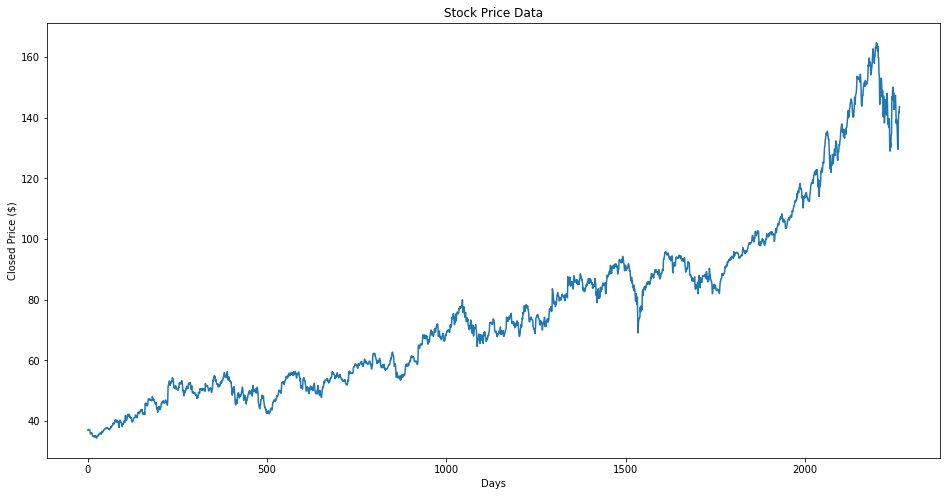

In [3]:
plt.figure(figsize=(16,8))
plt.title('Stock Price Data')
plt.xlabel('Days')
plt.ylabel('Closed Price ($)')
plt.plot(df['Close'])

In [24]:
df.set_index(df["Date"])
df_close = df.filter(["Close"])
split = math.ceil(len(df)*.7)

In [25]:
close = df_close.values
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(close)

In [26]:
train = scaled_data[:split]
test = scaled_data[split:]

In [27]:
x_train = []
y_train = []
for i in range(60, len(train)):
    x_train.append(train[i- 60:i,0])
    y_train.append(train[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [29]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [30]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/4
1526/1526 [==============================] - 21s 14ms/step - loss: 1.1710e-04
Epoch 2/4
1526/1526 [==============================] - 22s 14ms/step - loss: 1.2333e-04
Epoch 3/4
1526/1526 [==============================] - 22s 15ms/step - loss: 1.3020e-04
Epoch 4/4
1526/1526 [==============================] - 23s 15ms/step - loss: 1.1521e-04


In [44]:
test_data = scaled_data[split - 60: , : ]

In [45]:
x_test = []
y_test = close[split: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60 : i, 0])

In [46]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [47]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [48]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.6552263484839975

/Users/yonglertang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


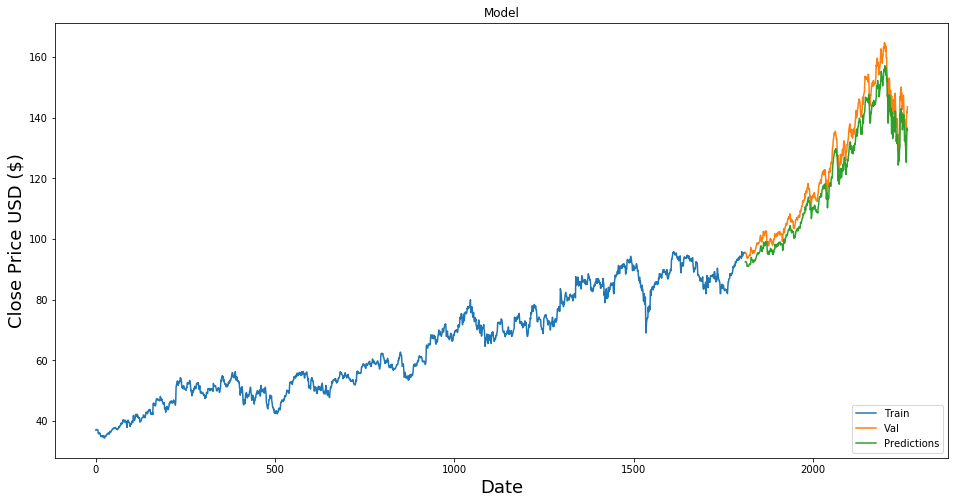

In [17]:
train = df_close[:split]
valid = df_close[split:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
valid

,Close,Predictions
1812,95.532003,92.528137
1813,95.567997,92.508232
1814,95.126999,92.545815
1815,95.010001,92.174988
1816,93.795003,92.067123
...,...,...
2260,129.597002,126.363441
2261,138.155997,125.291252
2262,142.079997,133.504929
2263,141.611993,136.674194


In [19]:
new_df = df.filter(['Close'])

last_60_days = new_df[-60:].values

for i in range(60, 415):
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predict = model.predict(X_test)
    predict_value = scaler.inverse_transform(predict)
    last_60_days = np.append(last_60_days, predict_value)
    last_60_days = np.reshape(last_60_days, (len(last_60_days), 1))

In [20]:
predictedValues = last_60_days[60:len(last_60_days)]
type(predictedValues)

numpy.ndarray

In [21]:
predictedValues = np.hstack(predictedValues)

In [22]:
lst = predictedValues
data2 = df_submission["Date"]
df1= pd.DataFrame({'Date':data2, 'Close':lst})

In [23]:
df1.to_csv('LSTM Model.csv', index=False)